In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 행(row) 다 보기
pd.set_option('display.max_rows', None)

# 열(column) 다 보기
pd.set_option('display.max_columns', None)

## 추세

- 상승, 하락, 비추세 3가지 패턴이함 존재함
    + 추세
        + 이동평균 MA7, MA20 비교하여 변곡점을 통해 상승, 하락 여부 판단
        + 일자별 주가폭이 상위 5%이면 상승, 하위 5%이면 하위로 판단
    + 확장
        + 추세를 기준으로 앞, 뒤 일자별 추세가 같으면 추세와 같게 판단

[*********************100%***********************]  1 of 1 completed

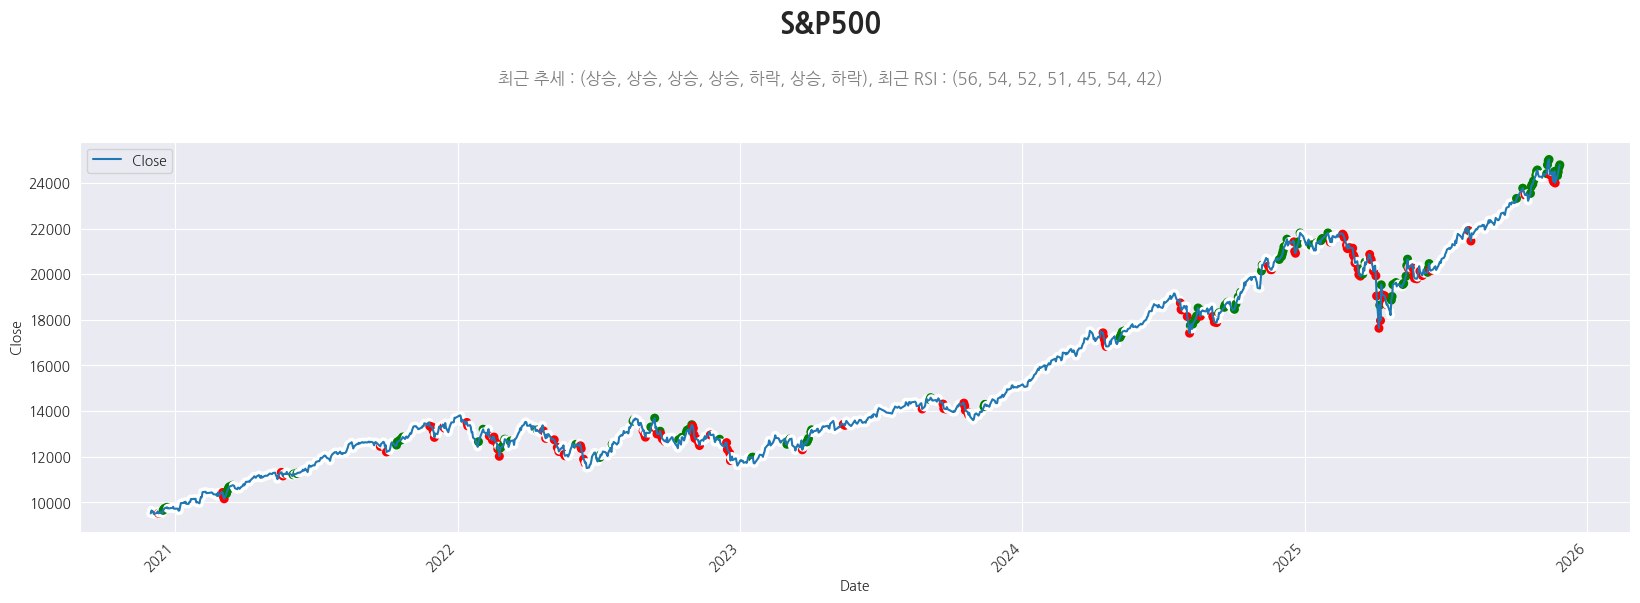

[*********************100%***********************]  1 of 1 completed

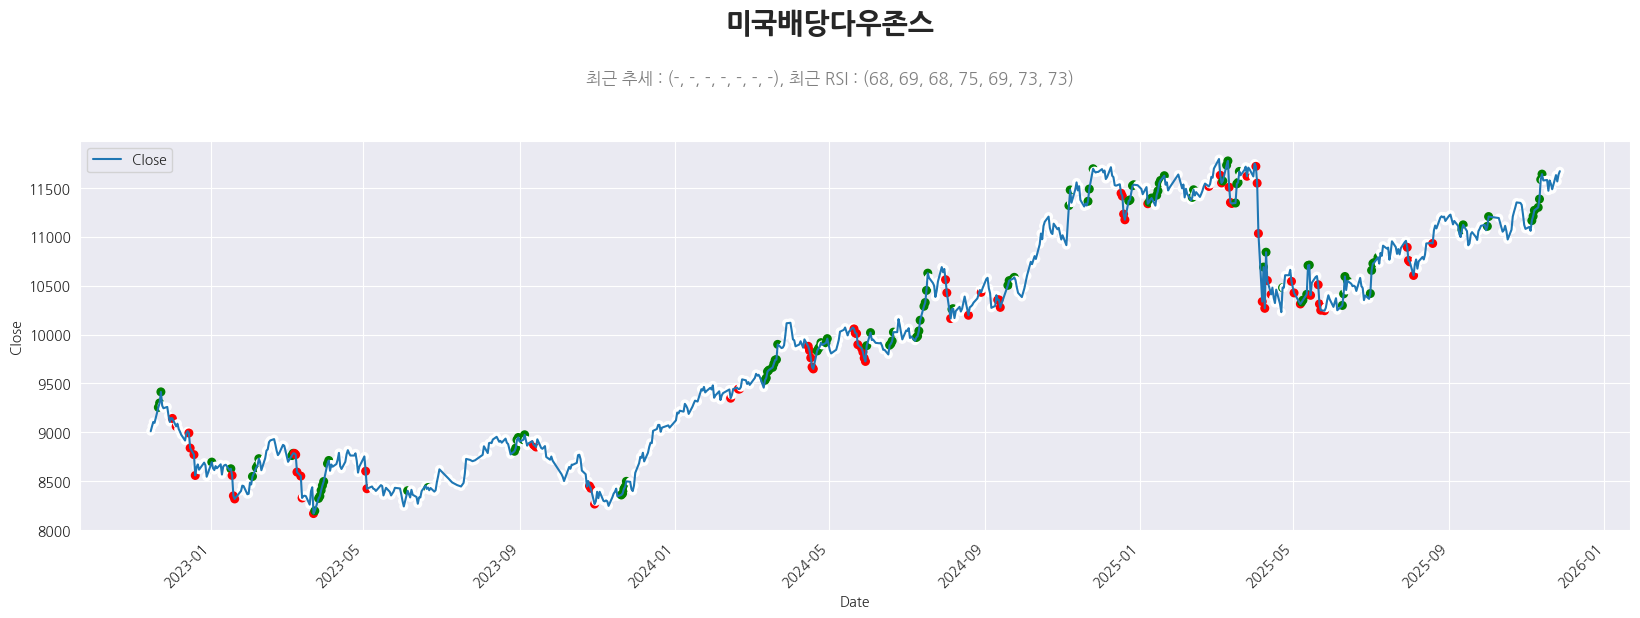

[*********************100%***********************]  1 of 1 completed

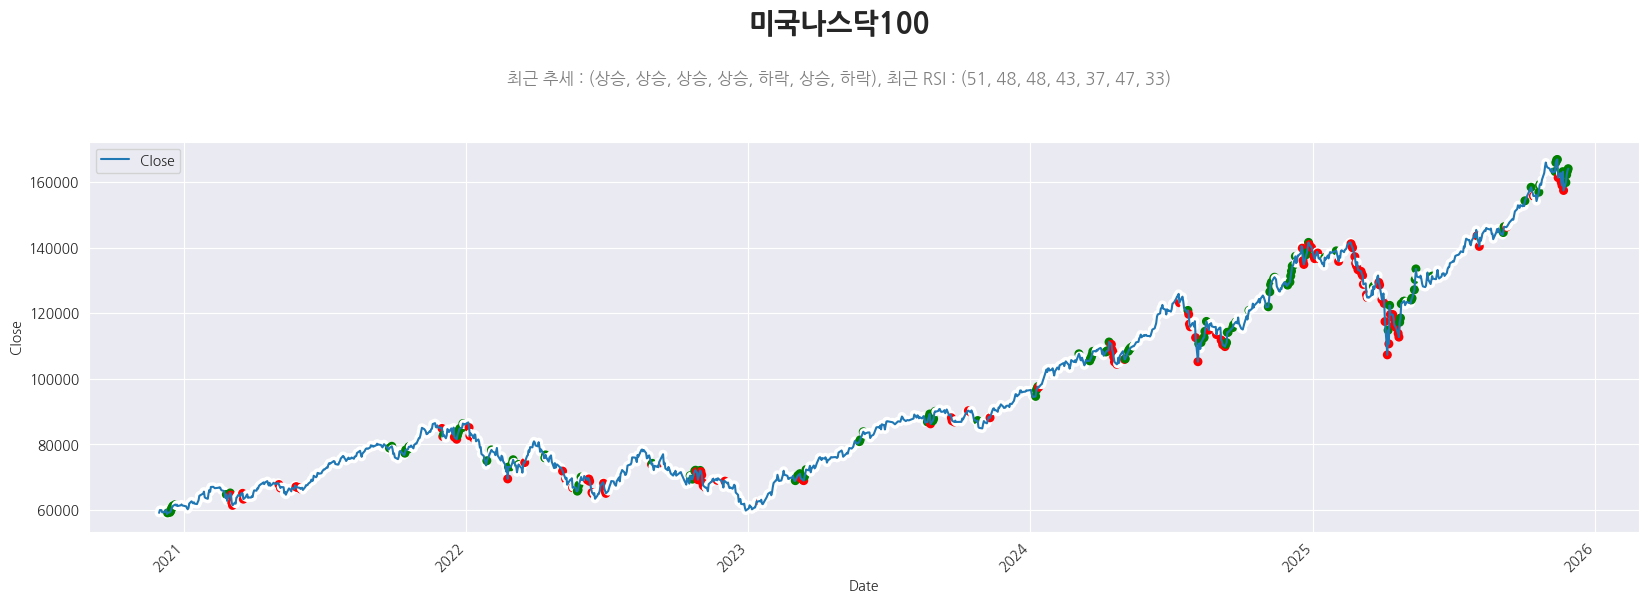

[*********************100%***********************]  1 of 1 completed

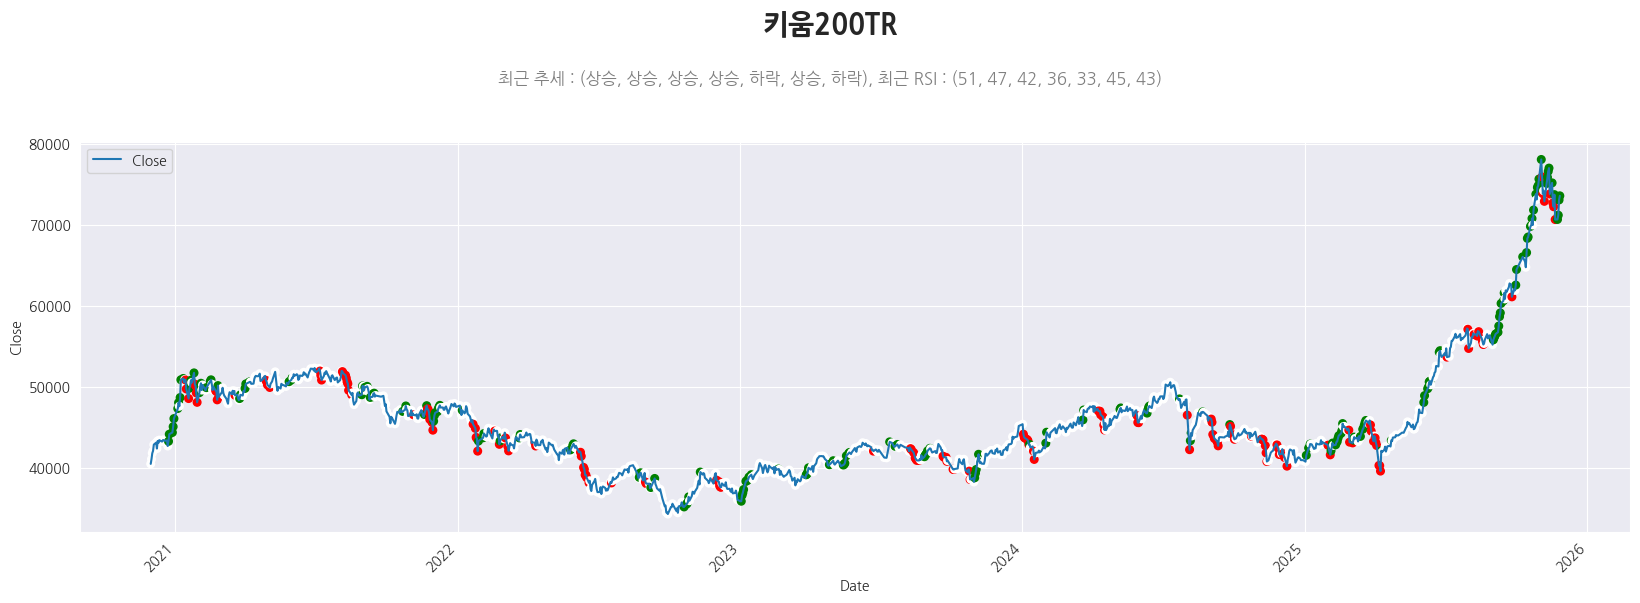

[*********************100%***********************]  1 of 1 completed

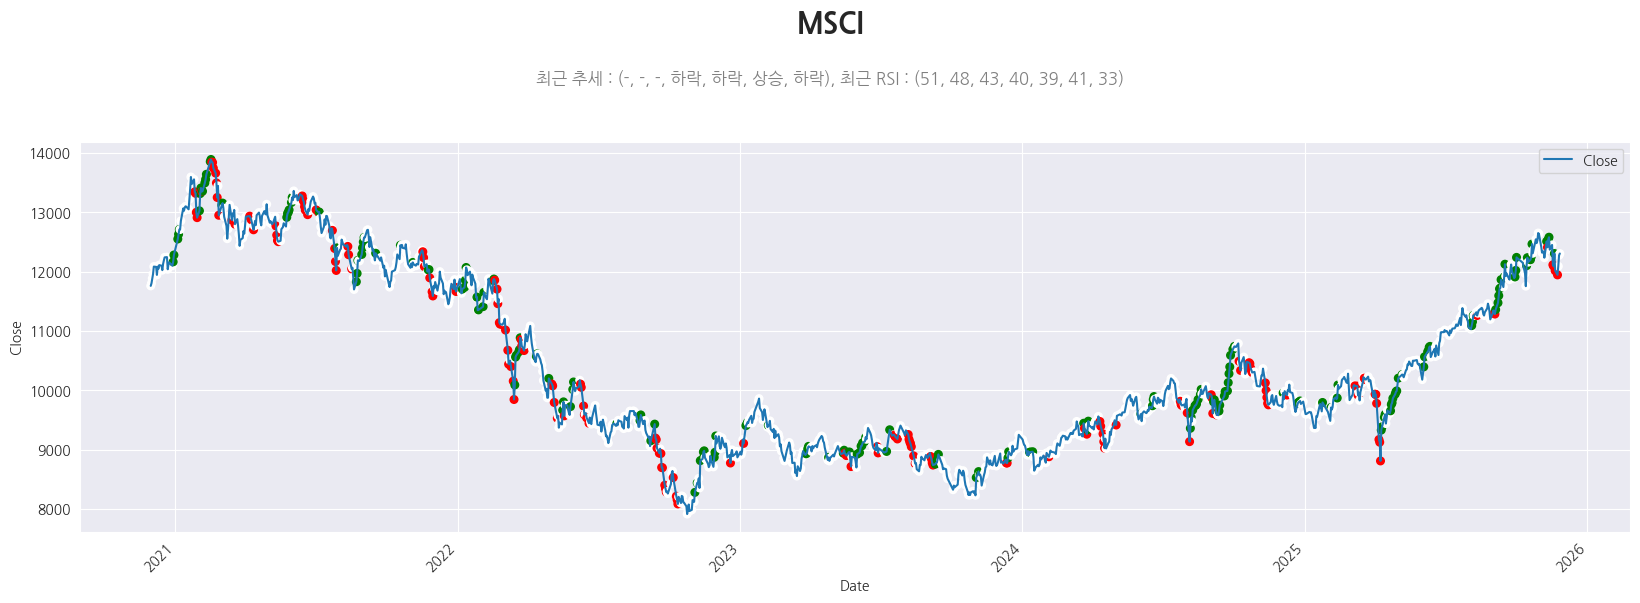

[*********************100%***********************]  1 of 1 completed

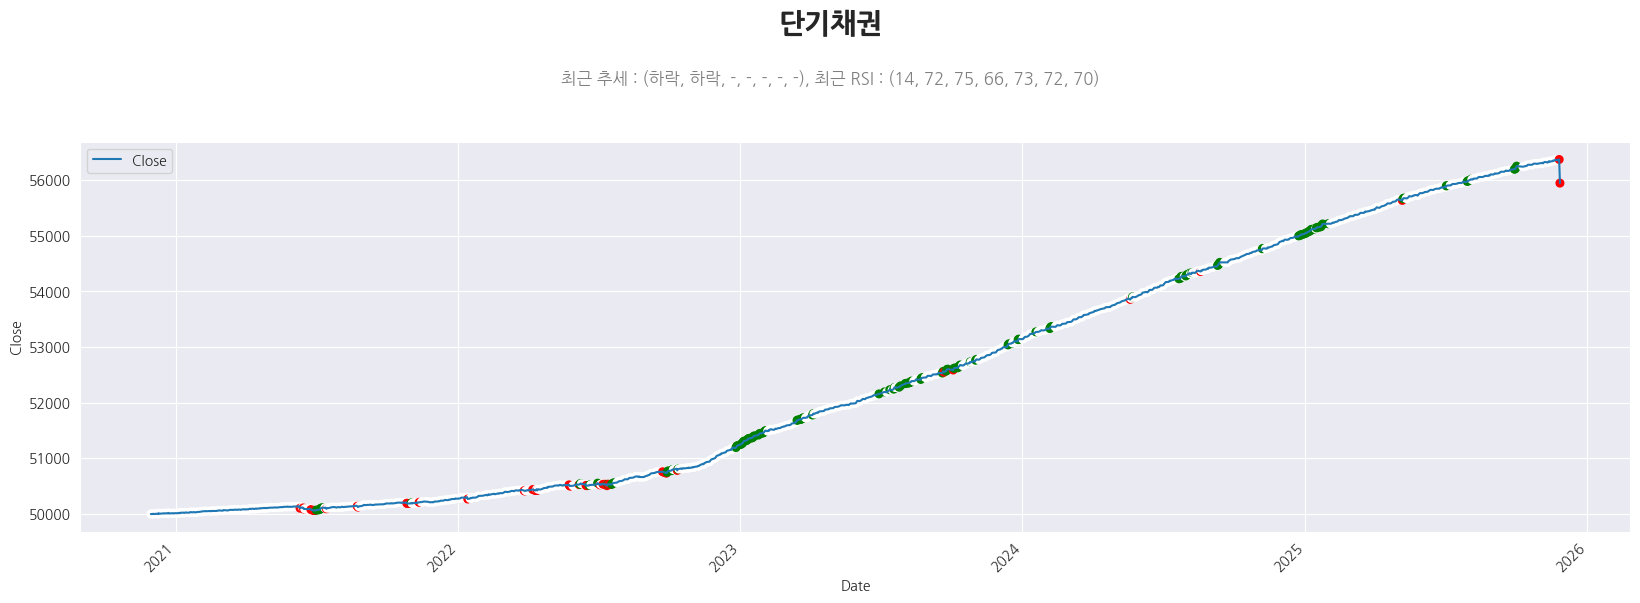

[*********************100%***********************]  1 of 1 completed

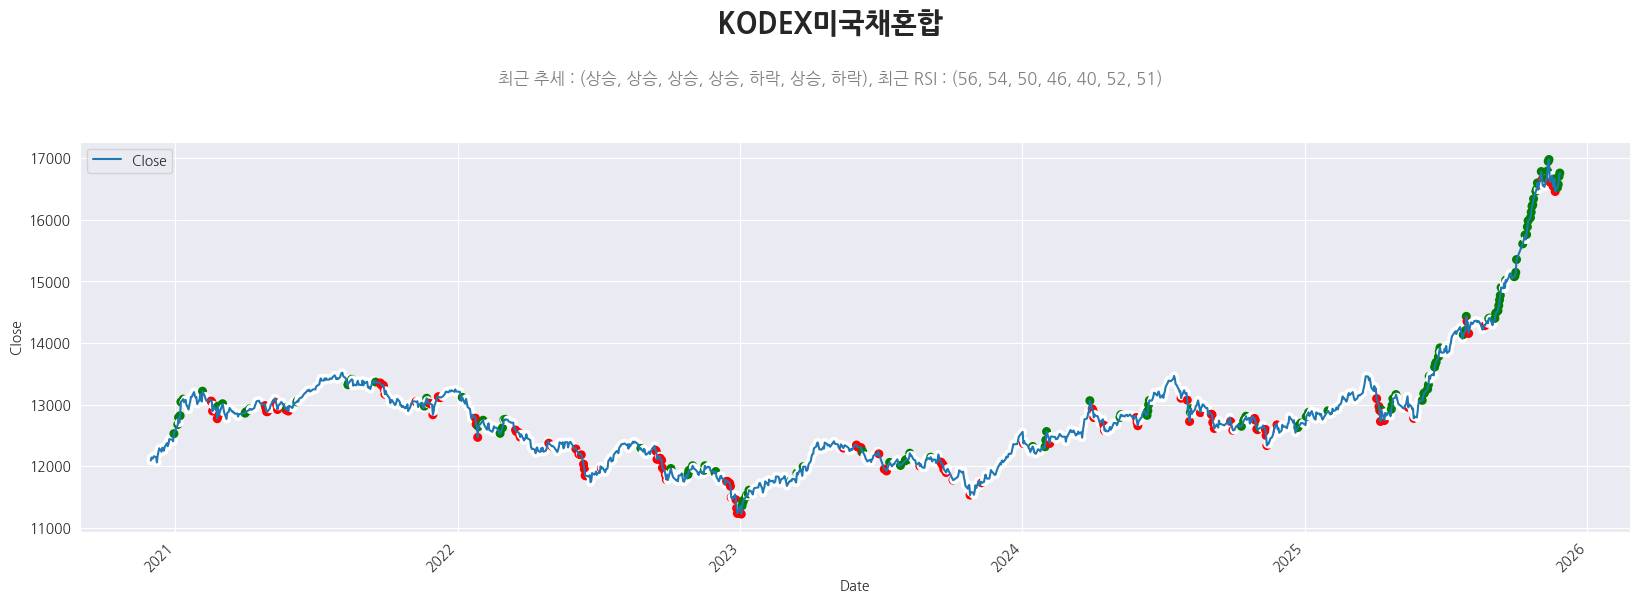

[*********************100%***********************]  1 of 1 completed

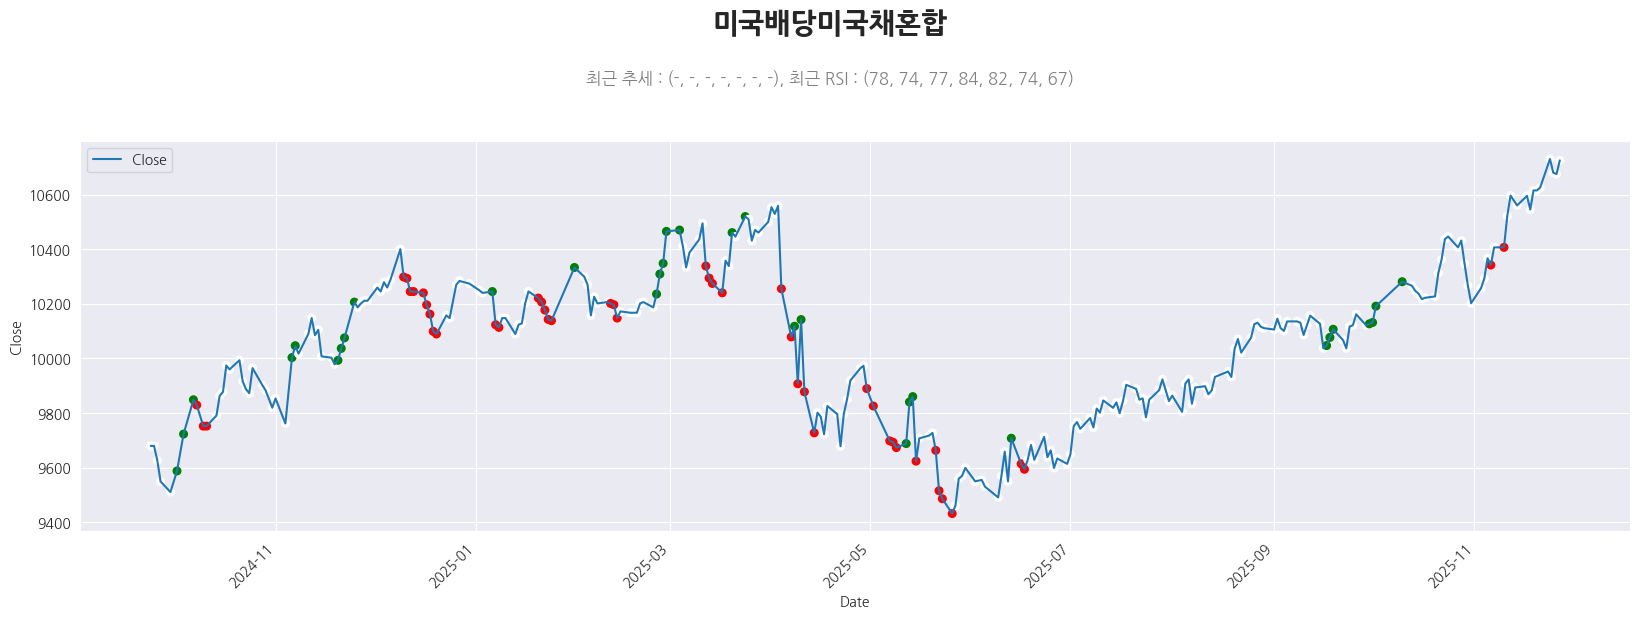

[*********************100%***********************]  1 of 1 completed

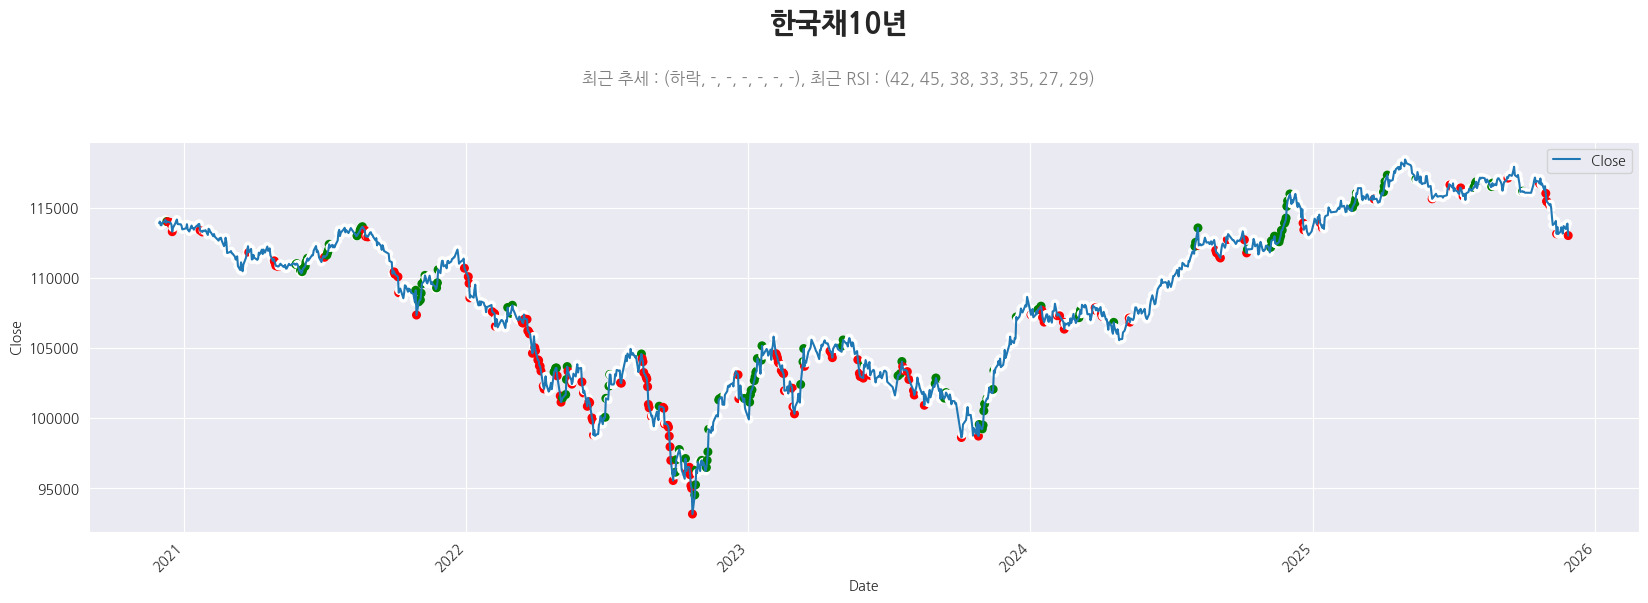

[*********************100%***********************]  1 of 1 completed

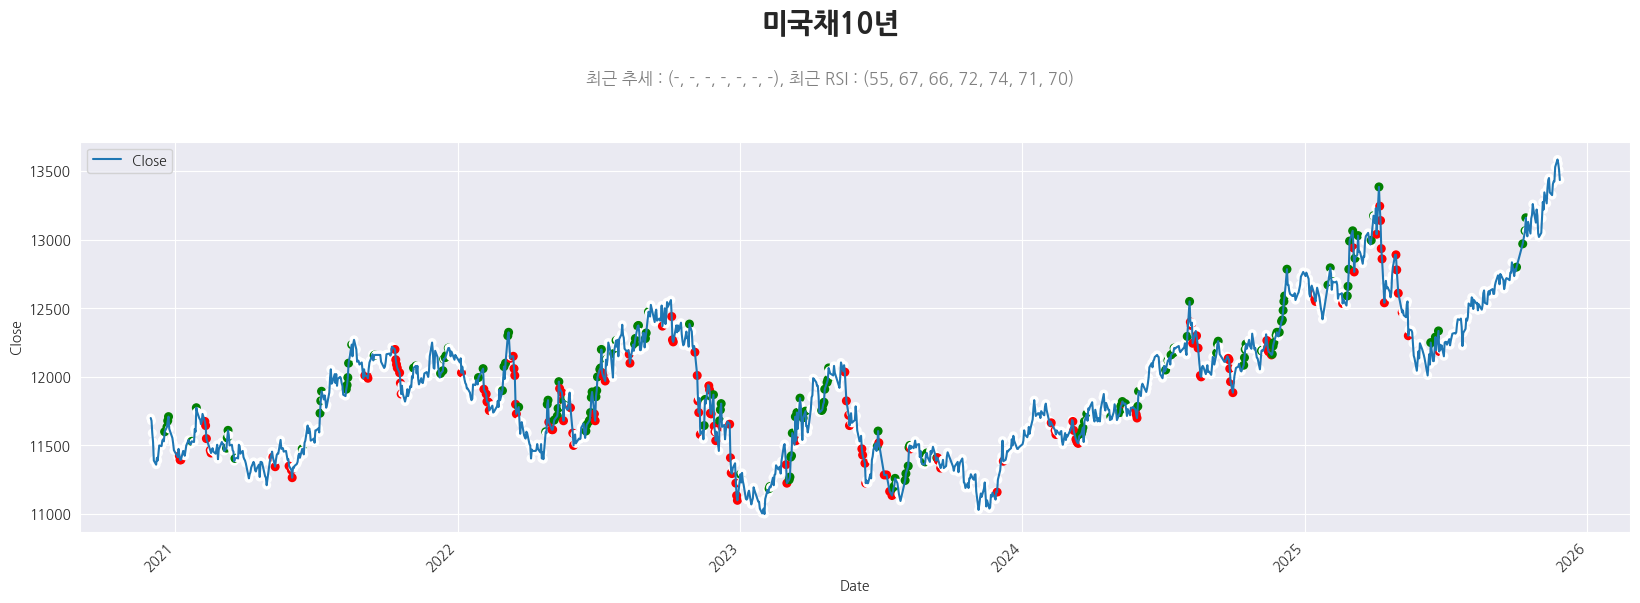

[*********************100%***********************]  1 of 1 completed

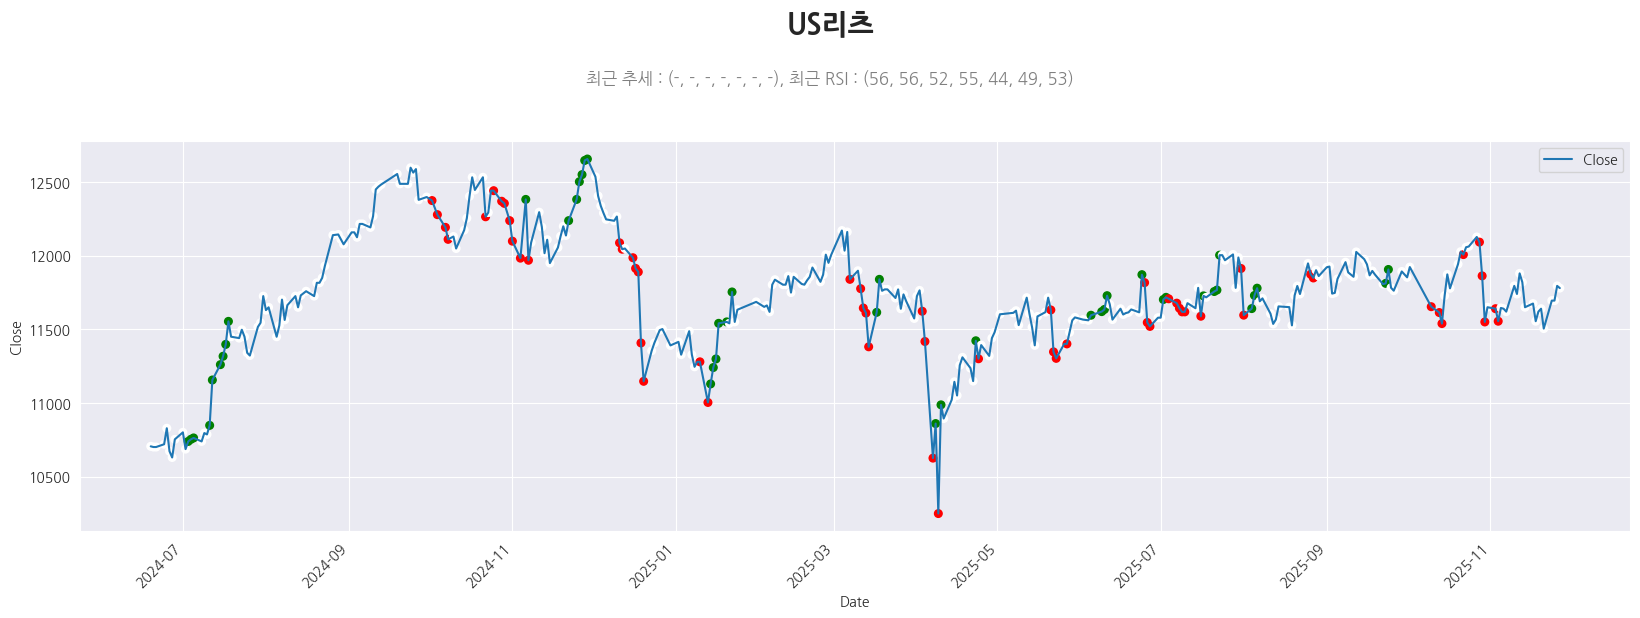

[*********************100%***********************]  1 of 1 completed

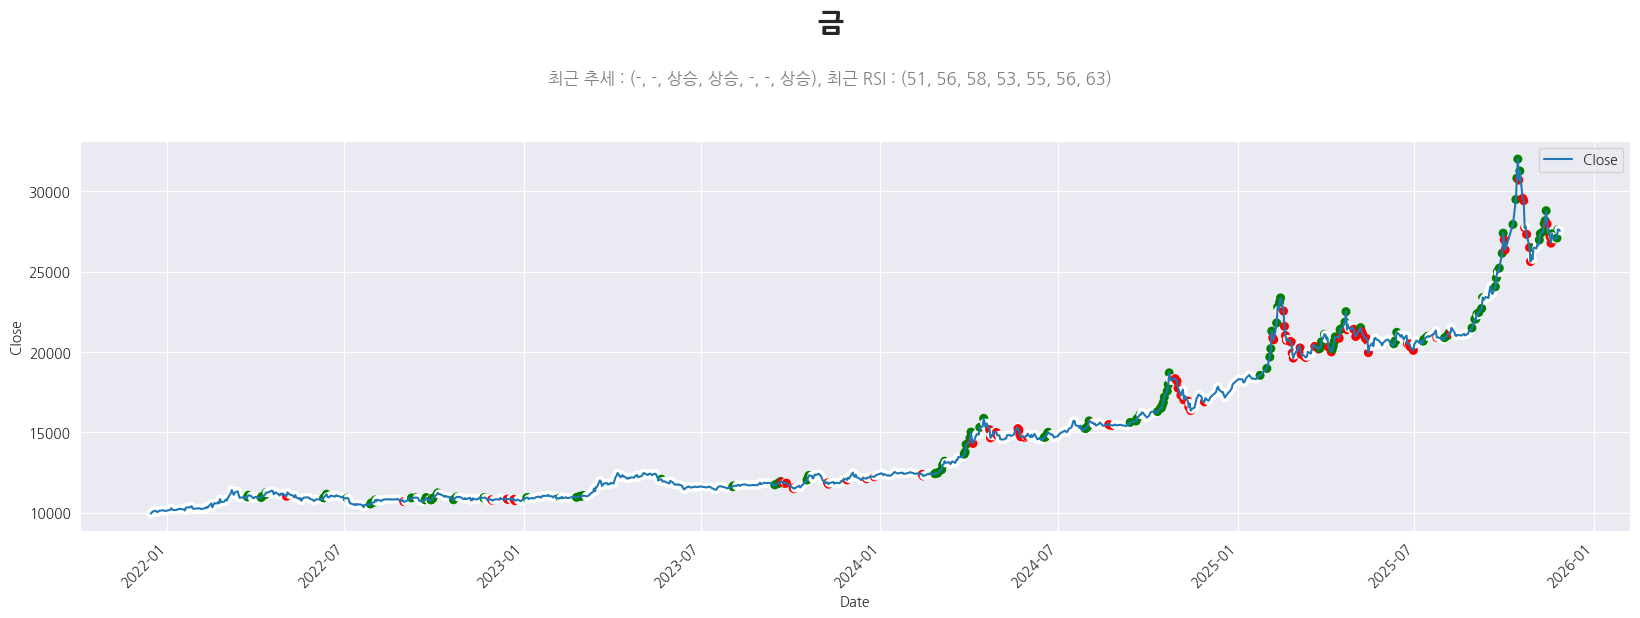

[*********************100%***********************]  1 of 1 completed

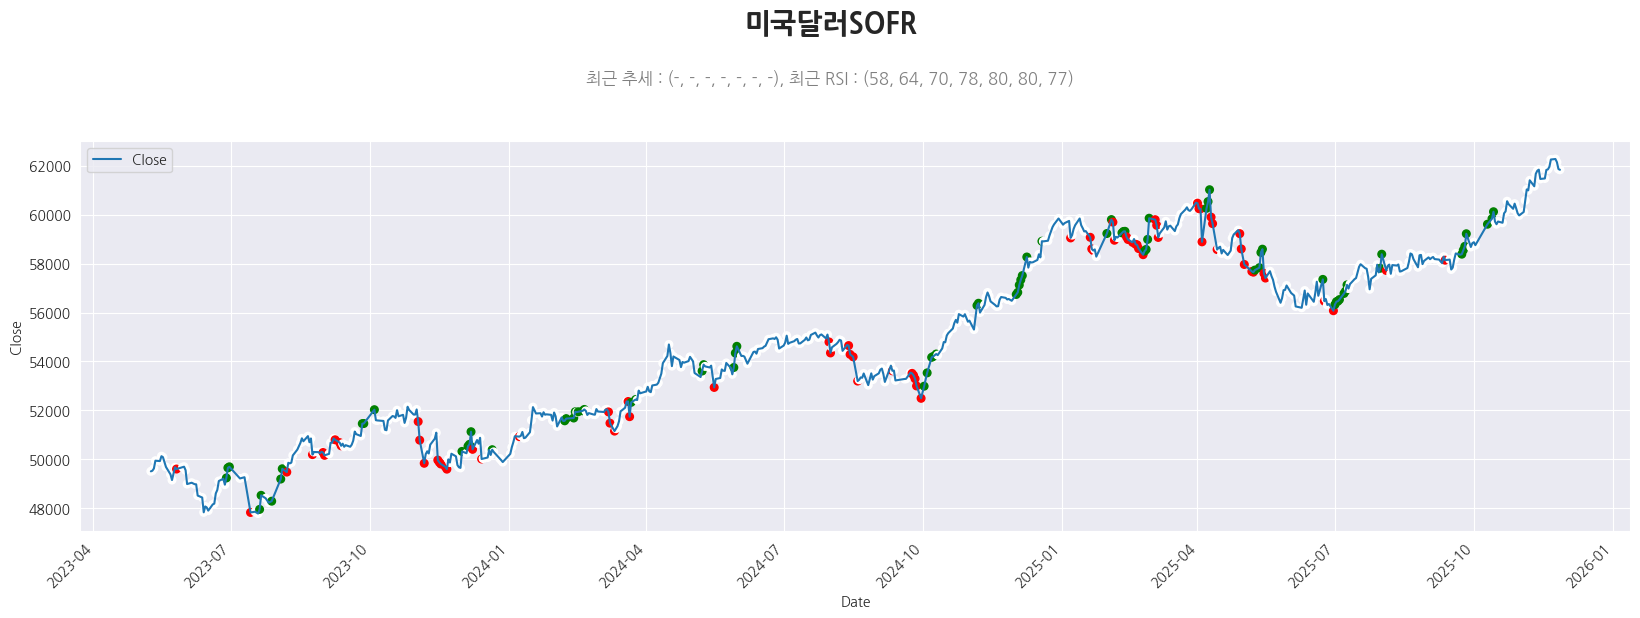

[*********************100%***********************]  1 of 1 completed

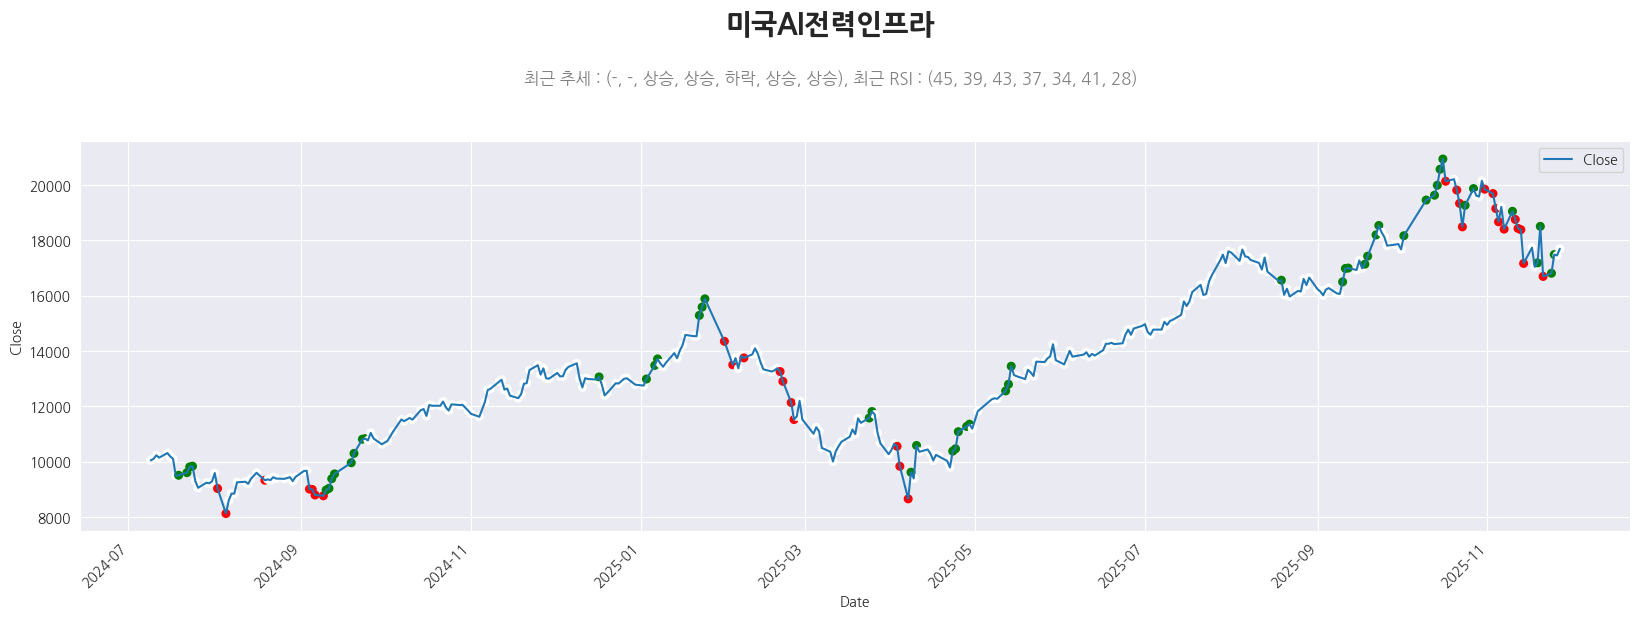

[*********************100%***********************]  1 of 1 completed

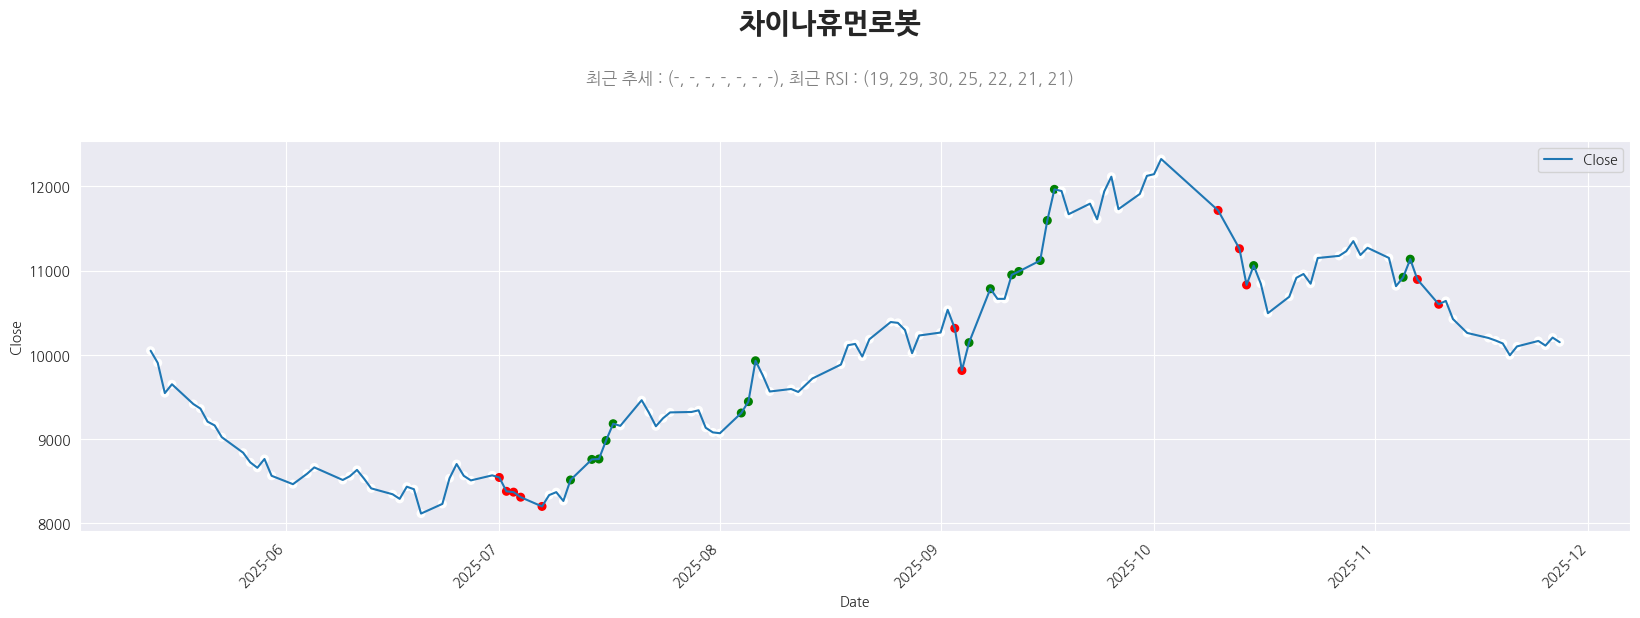

In [2]:
dict_tickers = {"360750.KS":"S&P500",  "446720.KS":"미국배당다우존스", "133690.KS":"미국나스닥100",
                "294400.KS":"키움200TR", "195980.KS":"MSCI",
                "272580.KS":"단기채권", "284430.KS":"KODEX미국채혼합", "490490.KS":"미국배당미국채혼합",
                "148070.KS":"한국채10년", "305080.KS":"미국채10년",
                "352560.KS":"US리츠", "411060.KS":"금", "456610.KS":"미국달러SOFR", "487230.KS":"미국AI전력인프라", "0048K0.KS":'차이나휴먼로봇' }


for ticker in dict_tickers.keys():
    # etf = yf.Ticker(ticker)
    # df = etf.history(period="3y", interval="1d")
    df = yf.download(ticker, period="5y", interval="1d", auto_adjust=True)
    df.columns = df.columns.get_level_values(0)
    df = df[['Close', 'Volume']]

    # 위치 시프트
    df['close_shifted'] = df['Close'].shift(1)
    df['close_diff'] = df['Close'].diff()


    # 4️⃣ RSI 계산 최근 14일(혹은 N일) 동안 상승폭/하락폭 평균 계산
    # delta = df['Close'].diff()
    up = df['close_diff'] .clip(lower=0)
    down = -1 * df['close_diff'].clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + RS))


    # 이동평균선 생성 7d, 20d, 60d
    df['MA7'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['MA60'] = df['Close'].rolling(window=60, min_periods=1).mean()

    # 단-장기 편차 및 변곡점
    df['mv_spread'] = df['MA7'] - df['MA20']
    df['mv_sign'] = df['mv_spread'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['mv_sign_change'] = df['mv_sign'].diff()

    # 트랜드 찾기
    df['chg_mv_trend'] = np.where(df['mv_sign_change'] == 2, '상승',
                              np.where(df['mv_sign_change'] == -2, '하락', '-'))

    upper_threshold = df['close_diff'].quantile(0.97)
    lower_threshold = df['close_diff'].quantile(0.03)
    df.loc[df['close_diff'] > upper_threshold, 'chg_mv_trend'] = '상승'
    df.loc[df['close_diff'] < lower_threshold, 'chg_mv_trend'] = '하락'

    df['chg_close_trend'] = np.where(
        (df['Close'] > df['close_shifted']) & (df['close_diff'] < 0), '-', #상승 약화'
        np.where((df['Close'] < df['close_shifted']) & (df['close_diff'] > 0), '-', #'하락 약화',
                 np.where(df['Close'] > df['close_shifted'], '상승', '하락'))
    )


    # --- Step 1. 동일 추세(상승/하락)끼리 그룹 번호 부여 ---
    grp = (df['chg_close_trend'] != df['chg_close_trend'].shift()).cumsum()

    # --- Step 2. 각 그룹별 trend가 무엇인지, 그리고 그 구간 내 chg_mv_trend 존재 여부 확인 ---
    summary = df.groupby(grp).agg(
        grp_close_trend=('chg_close_trend', 'first'),
        has_mv_signal=('chg_mv_trend', lambda x: any(x.isin(['상승','하락'])))
    )


    # --- Step 3. mv 시그널이 존재하는 그룹만 new_trend로 표시 ---
    df['grp'] = grp
    df = df.merge(summary, left_on='grp', right_index=True, how='left')
    df['trend'] = np.where(df['has_mv_signal'], df['grp_close_trend'], '-')


    plt.figure(figsize=(20,6))  # 그림 넓게
    sns.lineplot(x=df.index, y=df['Close'], label='Close')
    plt.scatter(df.index, df['Close'], c=np.where(df['trend'] == '하락', 'red', np.where(df['trend'] == '상승', 'green', 'white')), s=30)
    plt.suptitle('{}'.format(dict_tickers[ticker]), fontsize=20, fontweight='bold', y =1.02)

    # --- 3️⃣ 부제목(추가 텍스트) ---
    plt.figtext(
        0.5, 0.92,  # 제목 바로 아래 위치
        "최근 추세 : ({}), 최근 RSI : ({})".format(', '.join(df['trend'].values.tolist()[::-1][:7]), ', '.join( [ str(int(rsi)) for rsi in df['RSI'].values.tolist()[::-1][:7]])),
        ha='center', va='top',
        fontsize=12, color='gray'
    )
    # x축 레이블 회전
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    # --- 5️⃣ 여백 조정 (시각화 간 2줄 정도 띄움 효과) ---
    plt.subplots_adjust(top=0.8, bottom=0.15)  # top 낮추면 제목/부제목 위 여백 늘어남
    print("\n" * 2)  # 출력 간 두 줄 공백 추가 (그래프 사이 띄우기)
    plt.show()

---

In [560]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


# 아틀라시안 주가 데이터 (멀티인덱스 방지)
df = yf.download("TEAM", start="2020-10-01", end="2022-06-01", group_by="column")

# 혹시 멀티인덱스면 평탄화
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
df = df[['Close', 'Volume']]

# 위치 시프트
df['close_shifted'] = df['Close'].shift(1)
df['close_diff'] = df['Close'].diff()

# 이동평균선 생성 7d, 20d, 60d
df['MA7'] = df['Close'].rolling(window=7, min_periods=1).mean()
df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
df['MA60'] = df['Close'].rolling(window=60, min_periods=1).mean()

# 단-장기 편차 및 변곡점
df['mv_spread'] = df['MA7'] - df['MA20']
df['mv_sign'] = df['mv_spread'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df['mv_sign_change'] = df['mv_sign'].diff()

# 트랜드 찾기
df['chg_mv_trend'] = np.where(df['mv_sign_change'] == 2, '상승',
                          np.where(df['mv_sign_change'] == -2, '하락', '-'))

upper_threshold = df['close_diff'].quantile(0.97)
lower_threshold = df['close_diff'].quantile(0.03)
df.loc[df['close_diff'] > upper_threshold, 'chg_mv_trend'] = '상승'
df.loc[df['close_diff'] < lower_threshold, 'chg_mv_trend'] = '하락'

df['chg_close_trend'] = np.where(
    (df['Close'] > df['close_shifted']) & (df['close_diff'] < 0), '-', #상승 약화'
    np.where((df['Close'] < df['close_shifted']) & (df['close_diff'] > 0), '-', #'하락 약화',
             np.where(df['Close'] > df['close_shifted'], '상승', '하락'))
)


# --- Step 1. 동일 추세(상승/하락)끼리 그룹 번호 부여 ---
grp = (df['chg_close_trend'] != df['chg_close_trend'].shift()).cumsum()

# --- Step 2. 각 그룹별 trend가 무엇인지, 그리고 그 구간 내 chg_mv_trend 존재 여부 확인 ---
summary = df.groupby(grp).agg(
    grp_close_trend=('chg_close_trend', 'first'),
    has_mv_signal=('chg_mv_trend', lambda x: any(x.isin(['상승','하락'])))
)


# --- Step 3. mv 시그널이 존재하는 그룹만 new_trend로 표시 ---
df['grp'] = grp
df = df.merge(summary, left_on='grp', right_index=True, how='left')
df['trend'] = np.where(df['has_mv_signal'], df['grp_close_trend'], '-')



# # 초기화
# df['trend'] = '-'
#
# # 기준이 되는 날짜들
# for trend_value in ['상승', '하락']:
#     # 기준점 찾기
#     anchor_idx = df.index[df['chg_mv_trend'] == trend_value]
#
#     # 각각의 기준점별로 같은 방향의 연속 구간을 찾기
#     for anchor in anchor_idx:
#         # 기준 위치
#         pos = df.index.get_loc(anchor)
#
#         # 앞으로 확장
#         before = pos
#         while before > 0 and df.iloc[before - 1]['chg_close_trend'] == trend_value:
#             before -= 1
#
#         # 뒤로 확장
#         after = pos
#         while after < len(df) - 1 and df.iloc[after + 1]['chg_close_trend'] == trend_value:
#             after += 1
#
#         # 해당 구간 채우기
#         df.iloc[before:after + 1, df.columns.get_loc('trend')] = trend_value


df.head()

/var/folders/jk/1j1mgc7x11122bdp64mnjcf40000gp/T/ipykernel_60243/1313204431.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TEAM", start="2020-10-01", end="2022-06-01", group_by="column")
[*********************100%***********************]  1 of 1 completed


,Close,Volume,close_shifted,close_diff,MA7,MA20,MA60,mv_spread,mv_sign,mv_sign_change,chg_mv_trend,chg_close_trend,grp,grp_close_trend,has_mv_signal,trend
Date,,,,,,,,,,,,,,,,
2020-10-01,186.009995,984900,NaN,NaN,186.009995,186.009995,186.009995,0.0,0,NaN,-,하락,1,하락,False,-
2020-10-02,184.789993,1706200,186.009995,-1.220001,185.399994,185.399994,185.399994,0.0,0,0.0,-,하락,1,하락,False,-
2020-10-05,186.850006,1426400,184.789993,2.060013,185.883331,185.883331,185.883331,0.0,0,0.0,-,상승,2,상승,False,-
2020-10-06,189.880005,1380900,186.850006,3.029999,186.882500,186.882500,186.882500,0.0,0,0.0,-,상승,2,상승,False,-
2020-10-07,193.039993,855200,189.880005,3.159988,188.113998,188.113998,188.113998,0.0,0,0.0,-,상승,2,상승,False,-


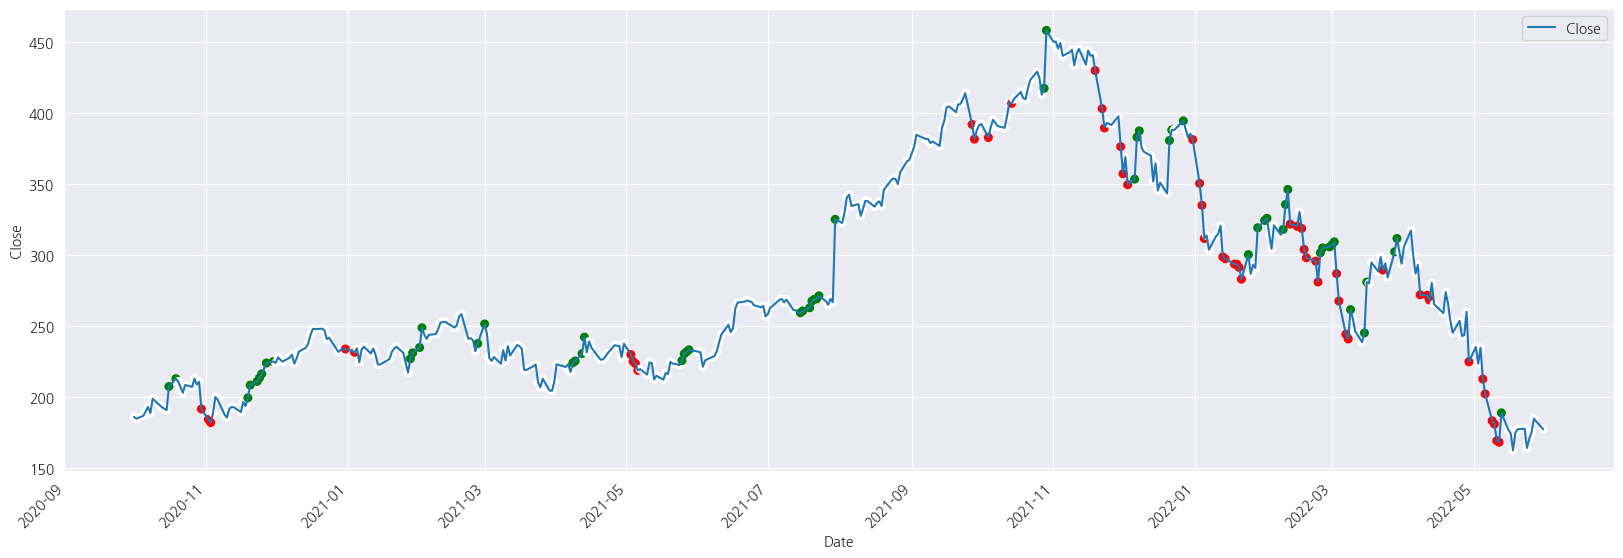

In [561]:
plt.figure(figsize=(20,6))  # 그림 넓게
sns.lineplot(x=df.index, y=df['Close'], label='Close')
# sns.lineplot(x=df.index, y=df['MA7'], label='MA7', color='grey')
# sns.lineplot(x=df.index, y=df['MA20'], label='MA20')
plt.scatter(df.index, df['Close'], c=np.where(df['trend'] == '하락', 'red', np.where(df['trend'] == '상승', 'green', 'white')), s=30)

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

In [523]:
# df_tmp = df['2021-10-10':'2022-01-20']
# plt.figure(figsize=(20,6))  # 그림 넓게
# sns.lineplot(x=df_tmp.index, y=df_tmp['Close'], label='Close')
# sns.lineplot(x=df_tmp.index, y=df_tmp['MA7'], label='MA7', color='grey')
# sns.lineplot(x=df_tmp.index, y=df_tmp['MA20'], label='MA20')
# # sns.lineplot(x=df_tmp.index, y=df_tmp['MA60'], label='MA60')
# plt.scatter(df_tmp.index, df_tmp['Close'], c=np.where(df_tmp['trend'] == '하락', 'red', np.where(df_tmp['trend'] == '상승', 'green', 'white')), s=30)
#
# # x축 레이블 회전
# plt.xticks(df_tmp.index, df_tmp.index.strftime("%Y%m%d"), rotation=90)
# plt.legend()
# plt.show()

In [504]:
# import yfinance as yf
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
#
# # 데이터 다운로드
# df = yf.download("TEAM", start="2020-10-01", end="2022-06-01", group_by="column")
#
# # 멀티인덱스 평탄화
# if isinstance(df.columns, pd.MultiIndex):
#     df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
#
# # 이동평균
# df['MA7'] = df['Close'].rolling(7, min_periods=1).mean()
# df['MA20'] = df['Close'].rolling(20, min_periods=1).mean()
#
# # spread와 slope 계산
# df['spread'] = df['MA7'] - df['MA20']
# df['slope'] = df['spread'].diff()
#
# # smoothing: 3일 EMA
# df['slope_ema'] = df['slope'].ewm(span=3, adjust=False).mean()
#
# # threshold 설정 (중요한 변화만 잡기)
# threshold = df['slope_ema'].std() * 0.3
#
# # trend 결정
# df['trend'] = df['slope_ema'].apply(
#     lambda x: '상승' if x > threshold else ('하락' if x < -threshold else '횡보')
# )
#
# # 색상 매핑
# color_map = {'상승': 'green', '하락': 'red', '횡보': 'lightgray'}
# df['color'] = df['trend'].map(color_map)
#
# # 시각화
# plt.figure(figsize=(15,6))
# plt.bar(df.index, df['Close'], color=df['color'], width=1)
# plt.plot(df['MA7'], label='MA7', color='blue', linewidth=1)
# plt.plot(df['MA20'], label='MA20', color='orange', linewidth=1)
# plt.title("TEAM 주가 추세 (중요한 변화만 표시)")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.show()


# import yfinance as yf
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
#
# # 데이터 다운로드
# df = yf.download("TEAM", start="2020-10-01", end="2022-06-01", group_by="column")
#
# # 멀티인덱스 평탄화
# if isinstance(df.columns, pd.MultiIndex):
#     df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
#
# # 이동평균
# df['MA7'] = df['Close'].rolling(7, min_periods=1).mean()
# df['MA20'] = df['Close'].rolling(20, min_periods=1).mean()
#
# # spread와 slope 계산
# df['spread'] = df['MA7'] - df['MA20']
# df['slope'] = df['spread'].diff()
#
# # EMA로 smoothing
# df['slope_ema'] = df['slope'].ewm(span=3, adjust=False).mean()
#
# # Percentile 기반 threshold 설정
# upper = df['slope_ema'].quantile(0.75)
# lower = df['slope_ema'].quantile(0.25)
#
# # 초기 trend 결정
# df['trend'] = df['slope_ema'].apply(
#     lambda x: '상승' if x > upper else ('하락' if x < lower else '횡보')
# )
#
# # 최소 연속일 필터 (3일 이상)
# min_days = 3
# trend_filtered = df['trend'].copy()
#
# for i in range(len(df) - min_days + 1):
#     window = df['trend'].iloc[i:i+min_days]
#     if all(window == '상승'):
#         trend_filtered.iloc[i:i+min_days] = '상승'
#     elif all(window == '하락'):
#         trend_filtered.iloc[i:i+min_days] = '하락'
#     else:
#         trend_filtered.iloc[i:i+min_days] = '횡보'
#
# df['trend_filtered'] = trend_filtered
#
# # 색상 매핑
# color_map = {'상승': 'green', '하락': 'red', '횡보': 'lightgray'}
# df['color'] = df['trend_filtered'].map(color_map)
#
# # 시각화
# plt.figure(figsize=(15,6))
# plt.bar(df.index, df['Close'], color=df['color'], width=1)
# plt.plot(df['MA7'], label='MA7', color='blue', linewidth=1)
# plt.plot(df['MA20'], label='MA20', color='orange', linewidth=1)
# plt.title("TEAM 주가 추세 (중요 변화만)")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

- 아엔비디아

In [562]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 엔비디아 주가 데이터 (멀티인덱스 방지)
df = yf.download("NVDA", start="2021-10-01", end="2024-05-01", group_by="column")

# 혹시 멀티인덱스면 평탄화
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
df = df[['Close', 'Volume']]

# 위치 시프트
df['close_shifted'] = df['Close'].shift(1)
df['close_diff'] = df['Close'].diff()

# 이동평균선 생성 7d, 20d, 60d
df['MA7'] = df['Close'].rolling(window=7, min_periods=1).mean()
df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
df['MA60'] = df['Close'].rolling(window=60, min_periods=1).mean()

# 단-장기 편차 및 변곡점
df['mv_spread'] = df['MA7'] - df['MA20']
df['mv_sign'] = df['mv_spread'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df['mv_sign_change'] = df['mv_sign'].diff()

# 트랜드 찾기
df['chg_mv_trend'] = np.where(df['mv_sign_change'] == 2, '상승',
                          np.where(df['mv_sign_change'] == -2, '하락', '-'))

upper_threshold = df['close_diff'].quantile(0.97)
lower_threshold = df['close_diff'].quantile(0.03)
df.loc[df['close_diff'] > upper_threshold, 'chg_mv_trend'] = '상승'
df.loc[df['close_diff'] < lower_threshold, 'chg_mv_trend'] = '하락'

df['chg_close_trend'] = np.where(
    (df['Close'] > df['close_shifted']) & (df['close_diff'] < 0), '-', #상승 약화'
    np.where((df['Close'] < df['close_shifted']) & (df['close_diff'] > 0), '-', #'하락 약화',
             np.where(df['Close'] > df['close_shifted'], '상승', '하락'))
)


# --- Step 1. 동일 추세(상승/하락)끼리 그룹 번호 부여 ---
grp = (df['chg_close_trend'] != df['chg_close_trend'].shift()).cumsum()

# --- Step 2. 각 그룹별 trend가 무엇인지, 그리고 그 구간 내 chg_mv_trend 존재 여부 확인 ---
summary = df.groupby(grp).agg(
    grp_close_trend=('chg_close_trend', 'first'),
    has_mv_signal=('chg_mv_trend', lambda x: any(x.isin(['상승','하락'])))
)


# --- Step 3. mv 시그널이 존재하는 그룹만 new_trend로 표시 ---
df['grp'] = grp
df = df.merge(summary, left_on='grp', right_index=True, how='left')
df['trend'] = np.where(df['has_mv_signal'], df['grp_close_trend'], '-')

/var/folders/jk/1j1mgc7x11122bdp64mnjcf40000gp/T/ipykernel_60243/2246449176.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("NVDA", start="2021-10-01", end="2024-05-01", group_by="column")
[*********************100%***********************]  1 of 1 completed


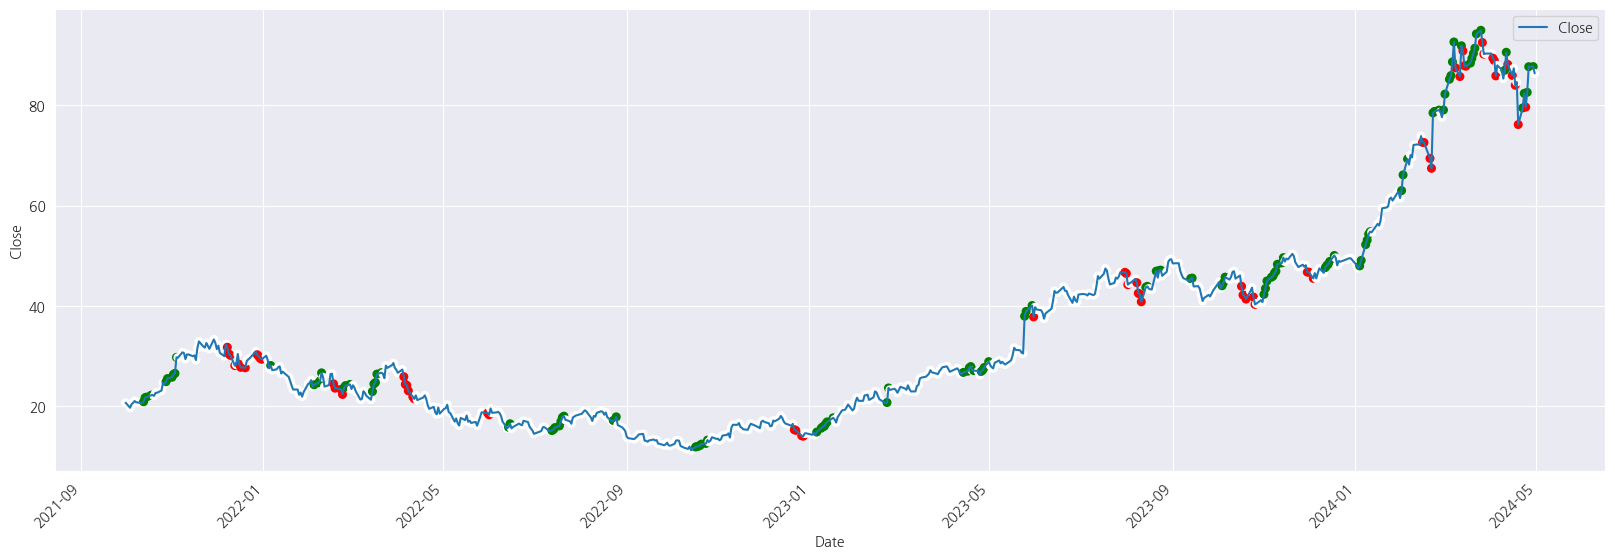

In [564]:
plt.figure(figsize=(20,6))  # 그림 넓게
sns.lineplot(x=df.index, y=df['Close'], label='Close')
plt.scatter(df.index, df['Close'], c=np.where(df['trend'] == '하락', 'red', np.where(df['trend'] == '상승', 'green', 'white')), s=30)

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

---